<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Predictive_Maintaince_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predictive Maintaince Classification**

Introduction of predictive approach and monitoring has to this day, prevented plenty of accidents and saved millions of dollars in plant downtime and equipment failure. In today’s competitive market, no business can afford unpredicted downtime or accidental machine breakdown. By implementing IoT-powered predictive maintenance (PdM) solutions, oil refining and petrochemical companies can maximize asset performance, increase operational performance, improve product quality, minimize downtime, and reduce costs.

In this case study I buuild a machine learning model that can predict the failure of the machinaery based of the set of parameter/features collected by IoT devices.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Explainatory Data Analysis](#3)
  4. [Featuring Engineering](#4)
  5. [Building ML Pipelines](#5)
  6. [Training ML models](#6)
  7. [Hyperparmeterization](#7)
  8. [Model Evaluation](#8)
  9. [Summary](#9)
  10. [Future Work](#10)
  11. [Reference](#11)


# 1: AboutDataset <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
- Target : Failure or Not
- Failure Type : Type of Failure

# 2: Loading the dataset Preprocessing <a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

We load the dataset from [kaggle](https://www.kaggle.com/datasets) using a custom made library opendatasets.

I also import other standard imports to perfrom data analysis, model building...etc

In [1]:
!pip install opendatasets 

In [2]:
# To Imporing dataset from kaggle
import opendatasets as od

# For data preprocessing
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTENC

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats
import pylab

# Librareis for building pipelines
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# To build ML models
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

To download the dataset from Kaggle you need to generate the API key from kaggle website. You can go through this [article](https://jovian.ai/forum/t/what-is-kaggle-api-key-how-to-get-my-kaggle-key/17721) to understand the process

In [3]:
# using pandas library to import the dataset
# Setting the data columns to index and for the convience to perfrom data analysis
od.download('https://www.kaggle.com/shivamb/machine-predictive-maintenance-classification')
df = pd.read_csv("/content/machine-predictive-maintenance-classification/predictive_maintenance.csv")
df.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hargurjeet
Your Kaggle Key: ··········


100%|██████████| 137k/137k [00:00<00:00, 20.5MB/s]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


Before we process any analysis it is important for us to check if any junk data is avaliable in our dataset, If yes then its needs to be cleaned up

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


It is observed that dataset doesnot contain any null values. This is great news !!!

Now the dataset has two target columns i.e. Target and Failure type. For the analysis of this case study I will choose the Target columns and proceed with my analysis

In [5]:
## Accessing the Target feature
print(df.Target.value_counts())

0    9661
1     339
Name: Target, dtype: int64


Checking the measure of central tendecy and disperssion of data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [7]:
# Columns not relvant for our analysis
df_relevant_features = df.drop('UDI', axis=1)

# 3: Explainatory Data Analysis <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

## 3.1 Visualizing all relevant featureas and Target columns

Text(0.5, 1.0, 'Failure Type')

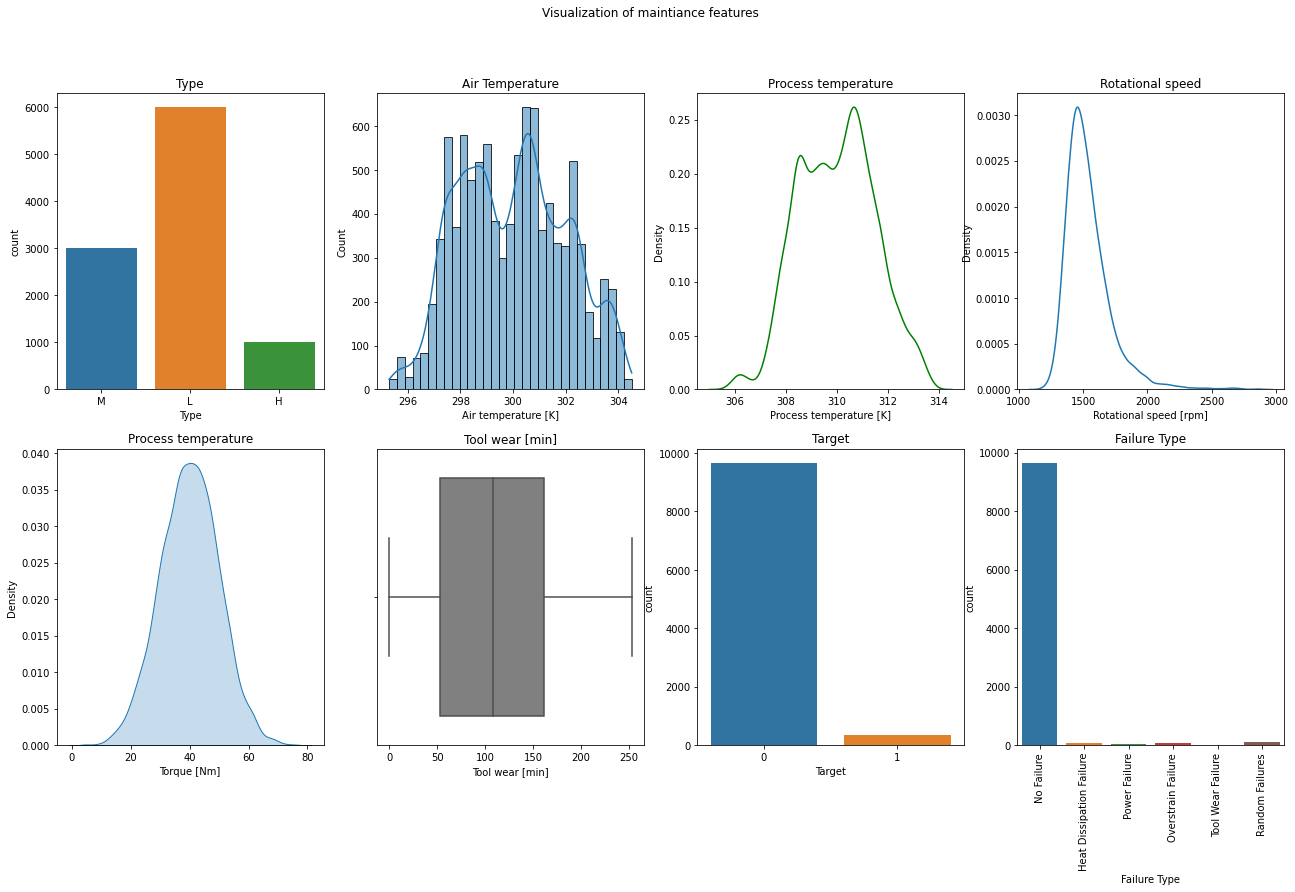

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(22,12))
fig.suptitle('Visualization of maintiance features')

#Type
sns.countplot(ax=axes[0,0], x=df_relevant_features.Type, data=df_relevant_features)
axes[0, 0].set_title('Type')

#Air Temperature
sns.histplot(ax=axes[0,1], x="Air temperature [K]", data=df_relevant_features, kde=True)
axes[0, 1].set_title("Air Temperature")

#Process temperature [K]	
sns.kdeplot(ax=axes[0,2], x="Process temperature [K]", data=df_relevant_features, color='green')
axes[0, 2].set_title("Process temperature")

# Rotational speed [rpm]
sns.kdeplot(ax=axes[0,3], x="Rotational speed [rpm]", data=df_relevant_features)
axes[0, 3].set_title("Rotational speed")

# Torque [Nm]
sns.kdeplot(ax=axes[1,0], x="Torque [Nm]", data=df_relevant_features, fill=True)
axes[1, 0].set_title("Process temperature")

#Tool wear [min]
sns.boxplot(ax=axes[1,1], x="Tool wear [min]", data=df_relevant_features, color='grey')
axes[1, 1].set_title("Tool wear [min]")

#Target
sns.countplot(ax=axes[1,2], x=df_relevant_features.Target, data=df_relevant_features)
axes[1, 2].set_title('Target')

#Failure Type
g = sns.countplot(ax=axes[1,3], x=df_relevant_features['Failure Type'], data=df_relevant_features)
g.set_xticklabels(labels = df_relevant_features['Failure Type'].value_counts().index, rotation=90)
axes[1, 3].set_title('Failure Type')

Insights - 
- As L, M and H represend the product quality. Low quality products are 6 times more than the high quality products.
- Data points at torque seems to be normally distributed. 
- The feature 'Target' are highly imbalanced, This will cause overfitting issue to one column, Hence an importance step would be to overcome the class imbalance.
- The distribution of Rational speed is left skewed.

## 3.2 Features relations

Finding and understanding the co relations between basic feature linkages


Text(0.5, 1.0, 'Co Relation plot')

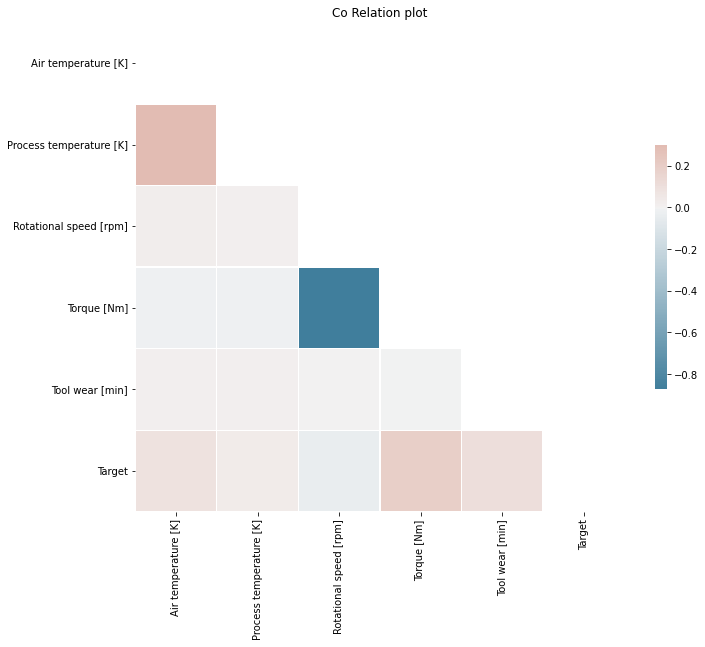

In [9]:
# Compute the correlation matrix
corr = df_relevant_features.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Co Relation plot')

In [10]:
df_relevant_features.corrwith(df_relevant_features['Target'], axis = 0)

Air temperature [K]        0.082556
Process temperature [K]    0.035946
Rotational speed [rpm]    -0.044188
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Target                     1.000000
dtype: float64

Insights - 
- Strong -ve co realtion between torque and rational speed.
- Tool wear in hihgly co realted to Target.
- Air Temperature and Process Temperature seems to be +ve co related.

In [11]:
df_relevant_features.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type'],
      dtype='object')

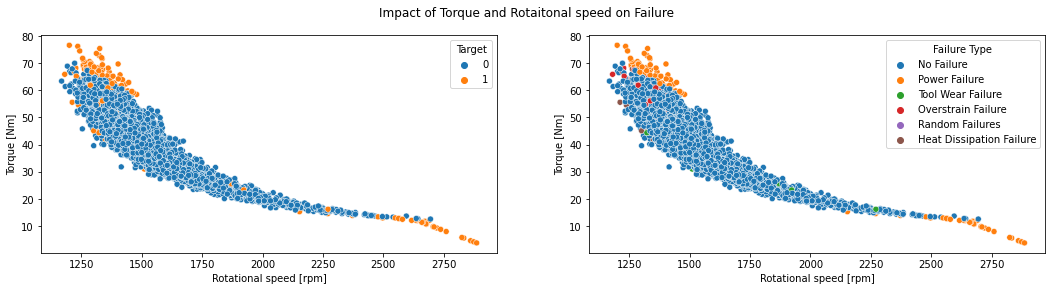

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18,4))
fig.suptitle('Impact of Torque and Rotaitonal speed on Failure')

#Target
# sns.countplot(ax=axes[0,0], x=df_relevant_features.Type, data=df_relevant_features)
sns.scatterplot(ax=axes[0], x="Rotational speed [rpm]", y= 'Torque [Nm]', data=df_relevant_features, hue='Target')
sns.scatterplot(ax=axes[1], x="Rotational speed [rpm]", y= 'Torque [Nm]', data=df_relevant_features, hue='Failure Type')

insights - 
- The chances of failure increase if the torque is too high or when the Roataional speed is too high.
- On high torque following failure are pre dominant
  - Power Failure
  - Obverstrain Failure
  - tool wear Fialure
  - Heat dessipation Failure

- On high rotational speeds, Power failure seems to be the only reason for cause of failure

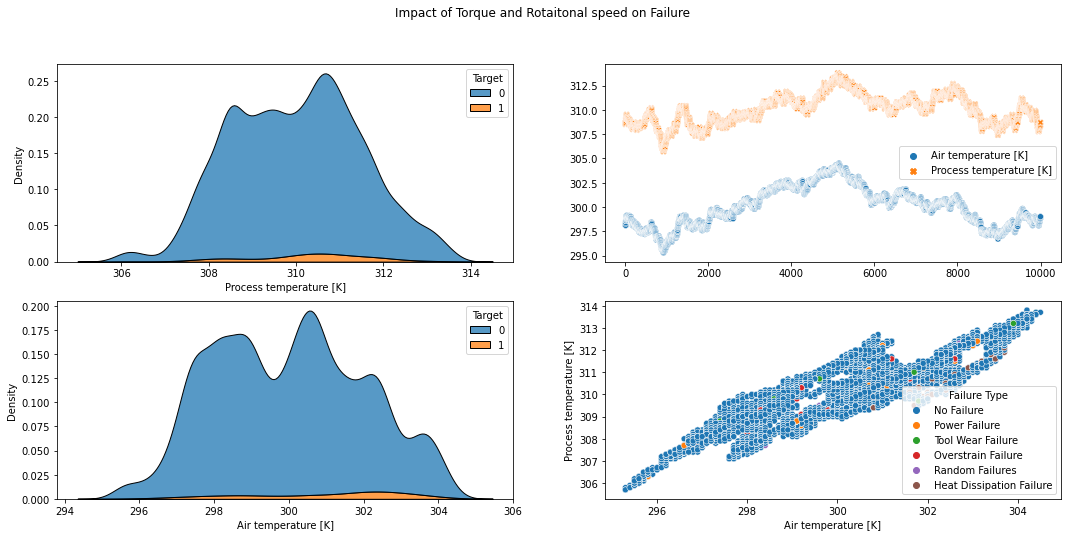

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(18,8))
fig.suptitle('Impact of Torque and Rotaitonal speed on Failure')

sns.kdeplot(ax=axes[0,0], data=df_relevant_features, x='Process temperature [K]', hue='Target', multiple="stack")
sns.scatterplot(ax=axes[0,1], data=df_relevant_features[['Air temperature [K]', 'Process temperature [K]']])
sns.kdeplot(ax=axes[1,0], data=df_relevant_features, x='Air temperature [K]', hue='Target', multiple="stack")
sns.scatterplot(ax=axes[1,1], data=df_relevant_features, x='Air temperature [K]', y='Process temperature [K]', hue='Failure Type')

Insights
- Air Temeprature and Process temperture are highly co related
- There is no clear realtionship btw failures and both the temperature variables
- Failure like Tool wear failure and overstrain failure is less likely to happen at lower levels of Air Temperature and Process Temperature

# 4: Featuring Engineering <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

As we observed during the initial analysis, there is high imbalance between targets we now implement SMOTE technique to overcome imbalance.

In [14]:
df_relevant_features.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [15]:
X = df_relevant_features[['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = df_relevant_features.Target

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# create artificial data with SMOTE
oversample = SMOTENC(categorical_features=[0], random_state=42)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

After implementing SMOTE class, Checking the targets

In [16]:
# count number of records in each class
count = Counter(y_train_smote)
print(count)

Counter({0: 7233, 1: 7233})


As the imbalance is taken care off now let us build pipeline to handle missing values, Standarizaiton, label encoding

# 5: Building ML Pipelines <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

Let us first segregate numberical and categorical columns. As we are building sklearn pipelines both of the columns types are needed to be handled seperately.

In [17]:
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes('object').columns.tolist()
print(numeric_cols)
print()
print(categorical_cols)

['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

['Type']


Below cells display the implementation of sklearn pipeline. On a high level following steps are requeired to be performed

- Numberical transformer - We pass all the nubmerical columns for inputation and scaling.

- Categorical transformer - here we pass all the categrocial columns for imputation and one hot encoding
- Preprocessor - The preprocessor object bundles up above two steps

In [18]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = np.nan, strategy='mean')),
    ('scaler', MinMaxScaler())
])


# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = np.nan , strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 6: Training ML models <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

As we are currently working on classification problem, I take the following ML model classifer and test out their perpormance.

In [19]:
# spot check some algorithms
classifier = []
classifier.append(('LR', LogisticRegression()))
classifier.append(('LDA', LinearDiscriminantAnalysis()))
classifier.append(('KNN', KNeighborsClassifier()))
classifier.append(('NB', GaussianNB()))
classifier.append(('SVM', SVC()))
classifier.append(('CTREE', DecisionTreeClassifier()))
classifier.append(('RFT', RandomForestClassifier()))

In [20]:
# Bundle preprocessing and modeling code in a pipeline
for model, clf in classifier:
  my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)
                                ,('model', clf)
                              ])
  # # Preprocessing of training data, fit model 
  my_pipeline.fit(X_train_smote, y_train_smote)

  # Preprocessing of validation data, get predictions
  preds = my_pipeline.predict(X_test)

  # Evaluate the model
  score = accuracy_score(y_test, preds)
  
  print('Accuracy:' + model, score)

Accuracy:LR 0.8296
Accuracy:LDA 0.83
Accuracy:KNN 0.9156
Accuracy:NB 0.5628
Accuracy:SVM 0.8972
Accuracy:CTREE 0.9488
Accuracy:RFT 0.9552


One of the best way to check your model performance is by training it through the cross validations. My pipelines really make it easy to setup the cross validations.

In [21]:
# test options
num_folds = 10
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, clf in classifier:
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)
                                ,('model', clf)
                              ])
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(my_pipeline, X_train_smote, y_train_smote, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.834024 (0.004687)
LDA: 0.831466 (0.005104)
KNN: 0.953339 (0.007348)
NB: 0.724250 (0.007073)
SVM: 0.916771 (0.007359)
CTREE: 0.961082 (0.005260)
RFT: 0.975529 (0.003982)


# 7: Hyperparmeterization <a name="7"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Random Forest seems to be having the best accuracy. Hence I choose random forest to further perform the hyperparameterizaiton to further enhance the model performace.

In [22]:
# KNN algorithm tuning
from sklearn.model_selection import GridSearchCV

grid_param = [
                 {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)
                                ,("classifier", RandomForestClassifier())
                              ])
gridsearch = GridSearchCV(my_pipeline, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train_smote,y_train_smote)

In [23]:
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_train_smote,y_train_smote))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(s

# 8: Model Evaluation <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [24]:
y_pred=gridsearch.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.94      2428
           1       0.18      0.83      0.29        72

    accuracy                           0.88      2500
   macro avg       0.59      0.86      0.61      2500
weighted avg       0.97      0.88      0.92      2500



# 9: Summary <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Following is the summary of the steps we performed while doing the analysis.

- Downloaded the dataset from Kaggle.
- Performed pre processing like checking for null values, removing redundant columns, importing all the required libraries.
- Performed explainatory data analysis
  - few key insights
    - Few features are normally distributed and few are highly skewed. 
    - Target feature is highly imbalanced.
    - Strong co realation between torque and rotational speed.
    - Air Temperature and Process Temperature seems to be +ve co related.
- Implemented SMOTE technique to overcome the class imbalance.
- Build sklearn pipelines and trained muliple ML models on top of those configured pipelines.
- Indentified the best model and performed hyperparametrization to further enchance the performance.

# 10: Future Work <a name="10"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- I have not tried boosted trees. Models like XGBoost and LightGBM can also be tried to check the performance.
- You can try building neural network and comapare the performace againt the developed ML model.

# 11: Reference <a name="11"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- https://www.kaggle.com/shivamb/machine-predictive-maintenance-classification